In [1]:

!pip install chess
!pip install networkx
!pip install pytorch-metric-learning
!pip install tqdm
!pip install torch_geometric
!pip install info-nce-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=e112157905e26ccb98dff4588e55965adb40b41b75ec2bea686e592439d3b19b
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import torch_geometric
import torch_geometric.utils as pyg_utils
from torch.utils.data import Dataset
import chess
import networkx as nx
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv,SAGEConv,GATConv,GINConv,TransformerConv,global_add_pool, global_mean_pool,global_max_pool,max_pool_neighbor_x
from torch_geometric.loader import DataListLoader,DataLoader
from sklearn.metrics import recall_score
# from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from info_nce import InfoNCE, info_nce
from pytorch_metric_learning import losses
import warnings
import chess.pgn
import chess
from tqdm import tqdm
import io
import random

warnings.filterwarnings("ignore")

In [3]:
def process_pgn_file(pgn_file_path):
    pgn = open(pgn_file_path)

    posdict ={ "fen": [],
                "capture": [],
                "first_five": [],
                "last_five":[],
                "label": []}

    for i in tqdm(range(33255)):
        game = chess.pgn.read_game(pgn)
        board = chess.Board()



        result_tag = game.headers["Result"]
        if result_tag == "1/2-1/2":
            continue  # Skip draws

        white_wins = (result_tag == "1-0")
        moves = list(game.mainline_moves())

        for idx, move in enumerate(moves):
            capture = board.is_capture(move)
            board.push(move)
            fen = board.fen()

            first_five = idx < 9
            last_five  = idx > (len(moves)-5)

            posdict["fen"].append(fen)
            posdict["capture"].append(capture)
            posdict["first_five"].append(first_five)
            posdict["last_five"].append(last_five)
            posdict["label"].append(white_wins)

    return posdict

In [4]:
pgn_file_path = '2024-01.bare.[33255].pgn'
game_data = process_pgn_file(pgn_file_path)

 21%|██        | 6983/33255 [01:42<06:25, 68.23it/s]


KeyboardInterrupt: 

In [5]:
def process_pgn_file2(pgn_file_path,_len):
    pgn = open(pgn_file_path)

    posdict = {
        "fen": [],
        "capture": [],
        "first_five": [],
        "last_five": [],
        "label": []
    }

    for i in tqdm(range(_len)):  # Assuming 33255 games to process
        game = chess.pgn.read_game(pgn)
        board = chess.Board()

        result_tag = game.headers["Result"]
        if result_tag == "1/2-1/2":
            continue  # Skip draws

        white_wins = (result_tag == "1-0")
        moves = list(game.mainline_moves())

        # Filter positions: not a capture and not within the first five moves
        eligible_positions = []

        for idx, move in enumerate(moves):

            capture = board.is_capture(move)
            board.push(move)
            first_five = idx < 9

            if not capture and not first_five:
                eligible_positions.append((board.fen(), idx, len(moves)))

        # If there are eligible positions, select a random one
        if eligible_positions:
            fen, idx, total_moves = random.choice(eligible_positions)
            last_five = idx > (total_moves - 5)

            posdict["fen"].append(fen)
            posdict["capture"].append(False)  # By definition, not a capture
            posdict["first_five"].append(False)  # By definition, not in the first five
            posdict["last_five"].append(last_five)
            posdict["label"].append(white_wins)

    return posdict

In [ ]:
dict_lst = []
pgn_file_path = '2024-01.bare.[33255].pgn'
dict_lst.append(process_pgn_file2(pgn_file_path,33255))
pgn_file_path = '2019-02.bare.[17169].pgn'
dict_lst.append(process_pgn_file2(pgn_file_path,17169))
pgn_file_path = '2019-03.bare.[20681].pgn'
dict_lst.append(process_pgn_file2(pgn_file_path,20681))
pgn_file_path = '2019-04.bare.[21283].pgn'
dict_lst.append(process_pgn_file2(pgn_file_path,21283))
pgn_file_path = '2019-01.bare.[22119].pgn'
dict_lst.append(process_pgn_file2(pgn_file_path,22119))
pgn_file_path = '2019-05.bare.[14181].pgn'
dict_lst.append(process_pgn_file2(pgn_file_path,14181))

posdict = {
        "fen": [],
        "capture": [],
        "first_five": [],
        "last_five": [],
        "label": []
    }
for dct in dict_lst:
    for key in posdict.keys():
        posdict[key] = posdict[key]+dct[key]

df = pd.DataFrame(game_data)
df2 = pd.DataFrame(posdict)
print(df.info())
print(df2.info())

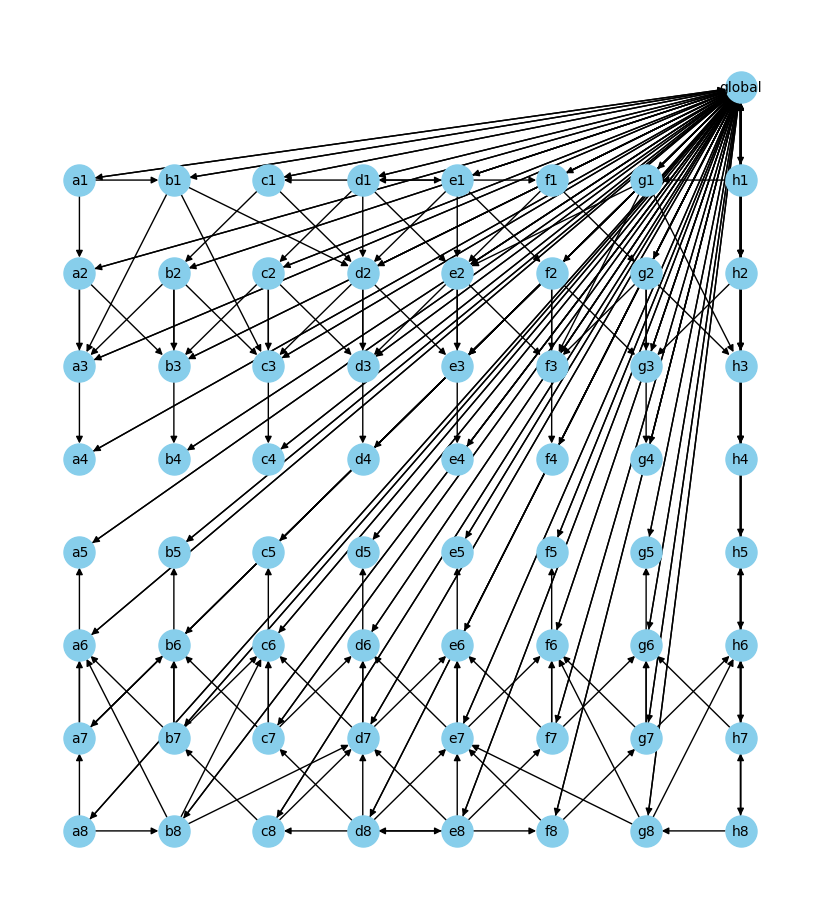

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def chess_position_to_graph(board):
    G = nx.DiGraph()  # Directed graph

    # Ensure all squares are included as nodes
    for square in chess.SQUARES:
        G.add_node(chess.square_name(square))
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Get all squares attacked by the piece on the current square
            attacked_squares = board.attacks(square)
            for target_square in attacked_squares:
                # Add a directed edge from the attacking square to the attacked square
                from_square_name = chess.square_name(square)
                to_square_name = chess.square_name(target_square)
                G.add_edge(from_square_name, to_square_name)
    # Get the legal moves for the current player
    current_moves = list(board.legal_moves)


    # Add edges for the current player's moves
    for move in current_moves:
        from_square_name = chess.square_name(move.from_square)
        to_square_name = chess.square_name(move.to_square)
        G.add_edge(from_square_name, to_square_name)

    # Temporarily switch turns to the opponent
    board.push(chess.Move.null())

    # Get the legal moves for the opponent
    opponent_moves = list(board.legal_moves)


    # Add edges for the opponent's moves
    for move in opponent_moves:
        from_square_name = chess.square_name(move.from_square)
        to_square_name = chess.square_name(move.to_square)
        G.add_edge(from_square_name, to_square_name)

    G.add_node("global")

    # Connect the global node to all squares
    for square in chess.SQUARES:
        square_name = chess.square_name(square)
        G.add_edge("global", square_name)  # Edge from global node to square
        G.add_edge(square_name, "global")  # Edge from square to global node

    # Restore the board to the original state
    # G = G.to_undirected()
    board.pop()

    return G

# Initialize the chess board
board = chess.Board()

# Convert the chess position to a graph
graph = chess_position_to_graph(board)

# Draw the graph
plt.figure(figsize=(8, 9))
pos = {chess.square_name(i): (i % 8, 7 - i // 8) for i in chess.SQUARES}
pos["global"] = (7,8)
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10, node_color='skyblue', arrows=True)
plt.show()

In [17]:
def square_to_coordinates(square):
    """Convert a square index to board coordinates."""
    row = square // 8 + 1
    col = square % 8 + 1
    return [col, row]

def distance_to_center(square):
    """
    Calculate the distance of a square to the center of the board.
    """
    row, col = divmod(square, 8)
    center_row, center_col = 3.5, 3.5  # Center of the board is at (3.5, 3.5)
    return np.sqrt((row - center_row) ** 2 + (col - center_col) ** 2) / 4.95  # Normalize distance


def piece_to_one_hot(piece):
    """Convert a chess piece to a one-hot encoding including color."""
    pieces = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    one_hot = [0] * 12
    if piece:
        one_hot[pieces[piece.symbol()]] = 1
    return one_hot
def piece_to_value(piece):
    pieces = {
        'P': 100, 'N': 320, 'B': 330, 'R': 500, 'Q': 900, 'K': 20000,
        'p': -100, 'n': -320, 'b': -330, 'r': -500, 'q': -900, 'k': -20000
    }
    if piece:
        return [pieces[piece.symbol()]]
    return [0]

def create_node_embeddings(board:chess.Board):
    embeddings = []
    for square in chess.SQUARES:
        coordinates = square_to_coordinates(square)
        piece = board.piece_at(square)
        piece_one_hot = piece_to_one_hot(piece)
        piece_value = piece_to_value(piece)
        center_distance = distance_to_center(square)
        is_attacked_white = int(board.is_attacked_by(True, square))
        is_attacked_black = int(board.is_attacked_by(False, square))
        is_check = int(board.is_check())
        embeddings.append(coordinates+piece_one_hot+piece_value+[center_distance]+[-1**(1-int(board.turn)),is_attacked_white,is_attacked_black,is_check])
    embeddings.append(torch.zeros(20))
    return torch.tensor(embeddings, dtype=torch.float)

def chess_position_to_torch_geometric_data(board):
    # Create the graph using the previous function
    G = chess_position_to_graph(board)

    # Convert the NetworkX graph to edge_index format for torch_geometric
    edge_index = pyg_utils.from_networkx(G).edge_index

    # Create node embeddings
    node_embeddings = create_node_embeddings(board)

    # Create the torch_geometric data object
    data = Data(x=node_embeddings, edge_index=edge_index)

    return data

# Initialize the chess board
board = chess.Board()

# Convert the chess position to a torch_geometric Data object
data = chess_position_to_torch_geometric_data(board)

# Display the data
data.edge_index



tensor([[ 0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,
          9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12,
         12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 48, 48, 48, 49, 49,
         49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52,
         53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56, 57,
         57, 57, 57, 58, 58, 58, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60,
         61, 61, 61, 62, 62, 62, 62, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64, 64, 64, 64,

In [11]:
class ChessPositionDataset(Dataset):
    def __init__(self, df):
        """
        Initialize the dataset by filtering the DataFrame to exclude
        capture moves and positions marked as first_five.

        :param df: DataFrame containing chess positions with columns:
                   'fen', 'capture', 'first_five', 'last_five', 'label'
        """
        # Filter the DataFrame to exclude capture moves and first five moves
        self.df = df[(~df['capture']) & (~df['first_five'])].reset_index(drop=True)
        self.df = self.df.groupby('fen').apply(self.determine_majority_label).reset_index().reset_index(drop=True)
        self.df.columns = ['fen', 'label']


    def determine_majority_label(self,group):
    # Determine the majority label (mode); if tied, select the first mode
        return group['label'].mode()[0]

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.df)

    def get_graph(self, fen):
        """
        Converts a FEN string into a graph representation using the provided
        function chess_position_to_torch_geometric_data.

        :param fen: FEN string representing the chess board state
        :return: Graph representation of the position
        """
        # Create a chess board from the FEN string
        board = chess.Board(fen=fen)

        # Generate the graph data using the chess_position_to_torch_geometric_data function
        graph_data = chess_position_to_torch_geometric_data(board)

        return graph_data

    def __getitem__(self, idx):
        """
        Returns a single sample from the dataset.

        :param idx: Index of the sample
        :return: Tuple (graph_data, label) where graph_data is the graph representation
                 of the position and label is its target label
        """
        # Get the FEN string and the label
        fen = self.df.loc[idx, 'fen']
        label = self.df.loc[idx, 'label']


        # Generate the graph representation of the position
        graph_data = self.get_graph(fen)

        # Convert label to a tensor
        label_tensor = torch.tensor(label, dtype=torch.float)

        return graph_data, label_tensor

# Example usage:

#dataset = ChessPositionDataset(df2)

In [ ]:
device = "cuda:0"
seed = 42 # age of SIPL
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False

dataloader=DataLoader(dataset, batch_size=128, shuffle=True,num_workers = 8)

In [ ]:
df_limited = df2[(~df2['capture']) & (~df2['first_five'])].reset_index(drop=True)
gt = torch.tensor(df_limited["label"])
class_counts = torch.bincount(gt.long())
total_samples = len(gt)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights

In [29]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2,aggr="mean"):
        super(GNN, self).__init__()

        # First GNN layer
        self.conv1 = SAGEConv(input_dim, hidden_dim,aggr=aggr)
        # self.conv1 = GINConv(nn=nn.Sequential(nn.LazyLinear(hidden_dim),nn.AdaptiveAvgPool1d(hidden_dim),nn.Tanh(),nn.LazyLinear(hidden_dim//2)),eps=0.007,train_eps=True)

        # Additional GNN layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim,aggr=aggr))
            # self.convs.append(GINConv(nn=nn.Sequential(nn.LazyLinear(hidden_dim),nn.AdaptiveAvgPool1d(hidden_dim),nn.Tanh(),nn.LazyLinear(hidden_dim//2)),eps=0.007,train_eps=True))
        # Fully connected layer to produce graph embedding
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128,1)

    def forward(self, data):
        # Extract relevant data from the Data object
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply the first GCN layer
        x = F.tanh(self.conv1(x, edge_index))

        # Apply the remaining GCN layers
        for conv in self.convs:
            x = F.tanh(conv(x, edge_index))

        # Pooling to get the graph-level embedding
        x = global_add_pool(x, batch)
        # x= max_pool_neighbor_x(x,batch)


        # Final fully connected layer
        x = F.leaky_relu(self.fc1(x),negative_slope=0.2)
        x= self.fc2(x)

        return x

# Example usage:
input_dim = 20  # Example: 2 for location + 12 for one-hot encoding of pieces
hidden_dim = 4*256
output_dim = 128  # Size of the graph embedding

model = GNN(input_dim=input_dim, hidden_dim=hidden_dim,num_layers=3,aggr="mean").to(device)





In [ ]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(weight=torch.tensor([0.8704]).to(device))  # Binary Cross-Entropy with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
# Training parameters
num_epochs = 200  # Number of epochs for training
losses= []
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize epoch loss
    i=0
    epoch_acc=0
    # epoch_recall = 0

    for batch in tqdm(dataloader):
        graphs, labels = batch  # Get graphs and labels from the DataLoader
        # print(graphs)
        # Move graphs and labels to GPU if available
        graphs = graphs.to('cuda:0' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Forward pass: Compute predicted outputs by passing graphs to the model
        outputs = model(graphs).squeeze()  # Squeeze the outputs to match the labels shape

        # Compute the loss
        loss = criterion(outputs, labels)


        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = torch.where(outputs>=0,1.0,0.0)
        batch_acc = torch.mean(torch.where(pred==labels,1.0,0.0))
        batch_recall = recall_score(labels.cpu(),pred.cpu())
        # Accumulate the loss for the epoch
        epoch_loss += loss.item()
        epoch_acc += batch_acc.item()
        # epoch_recall += batch_recall
        if (i+1)%2000 ==0:
                avg_loss = epoch_loss / (i+1)
                avg_acc = epoch_acc/(i+1)
                # avg_recall = epoch_recall/(i+1)
                print(f"Epoch [{epoch + 1}/{num_epochs}] data percent [{i+1}/{len(dataloader)}], Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
        i+=1
    # Compute the average loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    avg_acc = epoch_acc / len(dataloader)
    # avg_recall = epoch_recall/(len(dataloader))
    losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
    if losses[-1] <0.01:
         break
torch.save(model.state_dict(), 'chess_gnn_model.pth')